# 1D small network

In [1]:
# set fileName

fileName = "eg_1D_small-network"

In [2]:
# set libs

import pyNN.nest as sim
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt

/home/alberto-int/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'pynestkernel' does not match runtime version 3.7
  return f(*args, **kwds)


CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/alberto-int/anaconda3/lib/python3.7/site-packages/PyNN-0.9.5-py3.7.egg/pyNN/nest/__init__.py:53: UserWarning:Unable to install NEST extensions. Certain models may not be available.


In [3]:
# simulation setting

dt         = 1          # (ms)
syn_delay  = 1.0           # (ms)
simtime    = 1000.0        # (ms)
sim.setup(timestep=dt, max_delay=syn_delay)

/usr/lib/python3.5/dist-packages/nest/lib/hl_api_helper.py:127: UserWarning:
ResetNetwork is deprecated and will be removed in NEST 3.0.


0

In [4]:
# network parameters

n_pop = 20     # Number of cells
weight = 0.05  # synaptic weight (µS)

cell_params = {
    'tau_m'      : 20.0,   # (ms)
    'tau_syn_E'  : 2.0,    # (ms)
    'tau_syn_I'  : 4.0,    # (ms)
    'e_rev_E'    : 0.0,    # (mV)
    'e_rev_I'    : -70.0,  # (mV)
    'tau_refrac' : 2.0,    # (ms)
    'v_rest'     : -60.0,  # (mV)
    'v_reset'    : -70.0,  # (mV)
    'v_thresh'   : -50.0,  # (mV)
    'cm'         : 0.5}    # (nF)

# see parameters meaning in http://neuralensemble.org/docs/PyNN/standardmodels.html

In [5]:
# making the network
cells = sim.Population(n_pop, # number of cells
                       sim.IF_cond_exp, # cell model
                       cell_params, # cell parameters
                       label="cells")


NEST does not allow setting an initial value for g_ex
NEST does not allow setting an initial value for g_in


selected random sources [19, 4, 6, 5, 0]


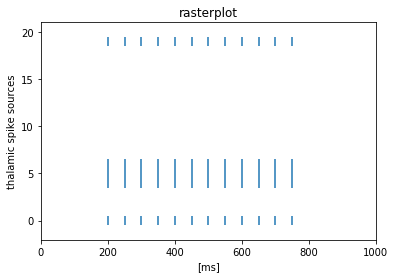

In [6]:
# designing the thalamic input

spike_times = [[]]*n_pop #list of spike lists, where one spike list is related to one spike source
random_sources_idx = [np.random.randint(0, n_pop) for i in range(5)]

for idx, sources in enumerate(random_sources_idx):
    #spike_times[sources] = [np.random.normal(loc=10, scale=0.1) for n in range(10)]
    spike_times[sources] = np.sort(np.arange(200, 800, 50).tolist())

spike_source = sim.Population(n_pop, sim.SpikeSourceArray(spike_times=spike_times))
spike_source.record('spikes')

input_conns = sim.Projection(spike_source, # from 
                             cells, # to
                             connector = sim.FixedProbabilityConnector(0.25), 
                             synapse_type = sim.StaticSynapse(weight=weight, delay=syn_delay),
                             receptor_type = 'excitatory')

fig, axes = plt.subplots(1,1)
axes_list = fig.axes
axes_list[0].eventplot(spike_times)
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('thalamic spike sources')
axes_list[0].set_title('rasterplot')
axes_list[0].set_xlim(0, simtime)
print('selected random sources', random_sources_idx)


In [7]:
# record state variables

cells.record(['spikes'])
cells.record(['v', 'gsyn_exc', 'gsyn_inh'])

In [8]:
# run simulation

sim.run(simtime)

#once you have run this cell, to rerun the simulation you have to restart the kernel (right-mouse-click) and clear the outputs

1000.0

In [9]:
# save results

outputs = cells.get_data() # on notebook space
cells.write_data(fileName + '.pkl', "spikes") # on folder

In [10]:
# recovering results

def recover_results(outputs):
    results = {}
    
    for analogsignal in outputs.segments[0].analogsignals:
        print(analogsignal.name)
        # to get voltage and conductances
        results[analogsignal.name] = analogsignal
        # to get spikes
        results['spikes'] = outputs.segments[0].spiketrains
    return results

In [11]:
# check results

results = recover_results(outputs)
results.keys()

gsyn_exc
v
gsyn_inh


dict_keys(['gsyn_exc', 'spikes', 'v', 'gsyn_inh'])

In [12]:
# check the mean firing rate

print("Mean firing rate: ", cells.mean_spike_count() * 1000.0 / simtime, "Hz")

Mean firing rate:  6.0 Hz


(0, 1000.0)

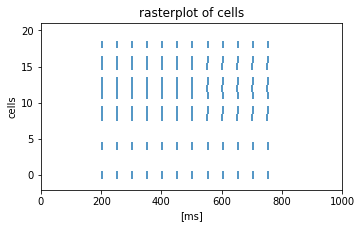

In [13]:
# check the spikes

fig, axes = plt.subplots(1, 1)
fig.tight_layout(pad=5)
axes_list = fig.axes

axes_list[0].eventplot(results['spikes'])
axes_list[0].set_title('rasterplot of cells')
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('cells')
axes_list[0].set_xlim(0, simtime)

In [14]:
random_sources_idx

[19, 4, 6, 5, 0]

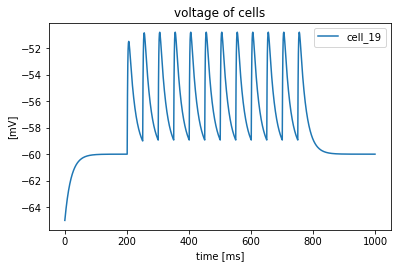

In [17]:
# check the voltage

pickedCell = random_sources_idx[0]

fig, axes = plt.subplots(1, 1)
fig.tight_layout(pad=3)

axes_list = fig.axes
axes_list[0].plot(results['v'].T[pickedCell], label='cell_' + str(pickedCell))

axes_list[0].set_title('voltage of cells')
axes_list[0].set_xlabel('time [ms]')
axes_list[0].set_ylabel('[mV]')
axes_list[0].legend()


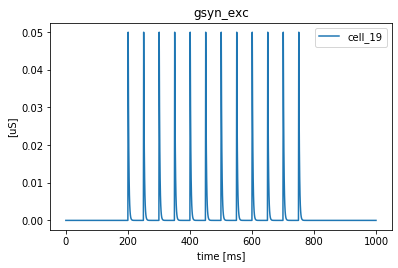

In [24]:
# check the conductance

pickedCell = random_sources_idx[0]

fig, axes = plt.subplots(1, 1)
fig.tight_layout(pad=5)

axes_list = fig.axes

for idx, conductance in enumerate(['gsyn_exc']):#, 'gsyn_inh']):

    fig.tight_layout(pad=3)
    axes_list = fig.axes
    axes_list[idx].plot(results[conductance].T[pickedCell], label='cell_' + str(pickedCell))
    axes_list[idx].set_title(conductance)
    axes_list[idx].set_xlabel('time [ms]')
    axes_list[idx].set_ylabel('[uS]')
    axes_list[idx].legend()

## task 1: on neuronal parameters

- change the tau_m (membrane time constant) parameter and have a look at the changes on the voltage trace.

- change other neuronal parameters and investigate their effect on the network behaviour

- info about parameters http://neuralensemble.org/docs/PyNN/standardmodels.html

## task 2: on neuronal model

- test another cell type looking at `sim.list_standard_models()`